# Домашняя работа 3 Логистическая Регрессия

сегодня мы узнаем как работать с классами и с классификацией с синтетическими данными и уже сформированными


#  Импорт данных


In [34]:
import numpy as np
import pandas as pd
from google.colab import files

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_moons, make_circles, make_classification

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1
import sklearn.metrics 



## Определяем функции для последующей работы

In [35]:
class LinearRegression():
    def __init__(self, # опредение линейной регрессии
                 learning_rate = 0.6, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        self.n_batches = n_batches
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X): # возвращает значения параметра и веса
        return np.dot(X, self.weights)
    
    #---------------------------------
    def loss(self,yhat, y): # определяет функцию потерь
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X): # определяет шаг в градиентном спуске
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    # обновляем веса после каждого шага град спуска
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size): # обновляем веса
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def predict(self, X): # предугадываем целевое значение
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    #---------------------------------
    def score(self, X, y):        # оцениваем насколько ошибается модель(метрика ...)
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))
    
    #---------------------------------
    def fit(self, X, y): # обучение модели

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size
            
        for i in range(self.epochs): 
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)): 

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]
    #---------------------------------
    def load_batch(self,X,y): # отсекаем выборку для последующей проверки
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #---------------------------------
    def add_bias(self, X): # добавляем отклонение
        return np.column_stack((np.ones(X.shape[0]), X))
    
    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''): # визуализируем функцию потерь
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self): # возвращаем веса и отклонение
        return (self.weights[1:], self.bias)

In [36]:
class ElasticRegression(LinearRegression): # линейная комбинация двух типов регуляризации
    def __init__(self, # Elastic net is a combination of the two most popular regularized variants of linear regression: ridge and lasso.
                 learning_rate = 0.5,
                 l1_penalty = 0.0, # для лассо легуляризации
                 l2_penalty = 0.0, # для ридж регуляризации
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate, # опреление суперкласса
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(self.weights[1:])/y.size
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))/y.size
        return np.square(yhat - y).mean() + l1_term + l2_term
                  
    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad + np.sign(self.weights)*self.l1_penalty  + l2_term)

In [37]:
def plot_data(ax,ds,name='',marker = 'o',colors =("#FF0000", '#0000FF'),alpha=0.7, s = 150, facecolor=True):
    X, y = ds

    cm_bright = ListedColormap(colors)
    ax.set_title(name, fontsize = 30)
    if facecolor:
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   alpha =alpha)
    else:
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   facecolor = 'None',
                   alpha =alpha)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    ax.grid(True)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

# Данные

Попробуем создать несколько вариантов данных для классификации.

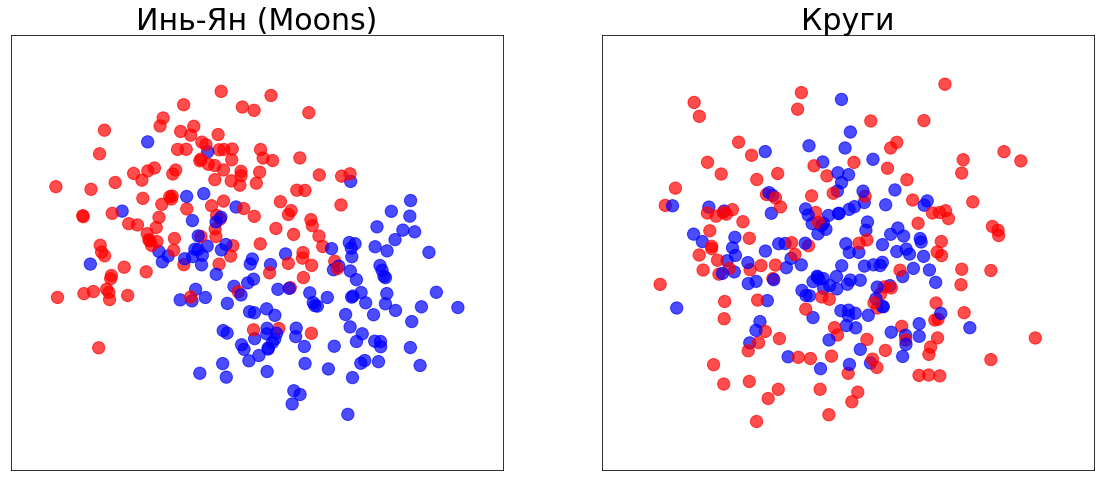

In [38]:
N = 250 #@param {type:"slider", min:50, max:250, step:25}


def make_binary_clf(N, method = 'line',
                    noises = 0.37,
                    random_state = 42):

    if random_state: rng = np.random.RandomState(seed = random_state)
    
    if method == 'line' or method is None:
        X, y = make_classification(n_samples=N, n_features=2,
                                   n_redundant=0, n_informative=2,
                                   n_clusters_per_class=1, class_sep=2,
                                   random_state=random_state)
        X += np.random.randn(*X.shape) *noises
        out = (X, y)


    elif method == 'moons':
        X, y = make_moons(n_samples=N, noise=noises, 
                          random_state=random_state)
    
    elif method == 'circles':    
        X, y = make_circles(n_samples=N, noise=noises, factor=0.5,
                            random_state=random_state )

    
    return X,y


fig=plt.figure(figsize=(30,8))

ax = plt.subplot(1, 3, 2)
plot_data(ax,make_binary_clf(N,method = 'moons'), 
          'Инь-Ян (Moons)')
ax = plt.subplot(1, 3, 3)
plot_data(ax, make_binary_clf(N,method = 'circles'),
          'Круги')




# Алгоритмы линейной классификации своими руками

## Логистическая регрессия

В лин регрессии мы хотим пройти через все точки или уменьшить расстояние между линией и точками. А логистическая регрессия же наоборот разделяет классы элементов.

In [69]:
_EPS_ = 1e-6

class LogisticRegression(ElasticRegression): # линейный классификатор 
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty    = 0.0,
                 l2_penalty    = 0.0,
                 epochs        = 100, 
                 weights       = None, 
                 bias          = None, 
                 threshold     = 0.5,
                 batch_size    = 1000, 
                 n_batches     = None,
                 random_state  = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state,
                         l1_penalty = l1_penalty,
                         l2_penalty = l2_penalty)       
        self.learning_rate = learning_rate/2
        self.threshold = threshold  # мы можем сказать, что если значение сигмоида больше 0.5 то пусть будет класс 1, а если меньше, то наоборот. Однако, на практике мы ставим более высокий порог, как правило 0.7 - 0.8
    #---------------------------------    
    def loss(self,yhat, y): # функцию потерь не стоит расчитывать до округления до классов
        
        l1_term = self.l1_penalty*np.sum(self.weights[1:])
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        
        return -(y*np.log(yhat  + _EPS_)+(1 - y)*np.log(1 - yhat  + _EPS_)).mean()\
            + l1_term+ l2_term   
    #---------------------------------
    def sigmoid(self, z):  # результат сигмоида(логит) - это вероятность того, что аргумент функции (z) принадлежит одному из классов
        return 1 / (1 + np.exp(-z))     
    #---------------------------------
    def forward(self, X):     
        return self.sigmoid(np.dot(X, self.weights))   
    #---------------------------------
    def to_class(self,logit):
        return (logit>=self.threshold)*1   
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return self.to_class(yhat)

    #---------------------------------
    def predict_prob(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat 
    #---------------------------------
    def score(self, X, y):
        yhat  = self.predict(X)
        return sum((yhat==y)*1)/y.size
    #---------------------------------
    def plot_decision_function(self,X,y,figsize = (12,6),
                               marker = 'o',colors =("#FF0000", '#0000FF'),
                               alpha=0.7, s = 150, poly = False, order = 2):
        plt.figure(figsize = figsize)
        cm_bright = ListedColormap(colors)
        plt.scatter(X[:, 0], X[:, 1],marker = marker, c=y, cmap=cm_bright,s = s, alpha =alpha);
        h =  (X[:, 0].max() - X[:, 0].min())/50
        x_min, x_max = X[:, 0].min()-0.5 , X[:, 0].max()+0.5
        y_min, y_max = X[:, 1].min()-0.5 , X[:, 1].max()+0.5    
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))
        if poly:
            Z = self.predict_prob(to_polynom(np.c_[xx.ravel(), yy.ravel()],order))-0.5
        else:
            Z = self.predict_prob(np.c_[xx.ravel(), yy.ravel()])-0.5
        cm = plt.cm.RdBu
        Z = Z.reshape(xx.shape) 
        plt.contourf(xx, yy, Z, cmap=cm, alpha=.5)
        plt.xticks([],[])
        plt.yticks([],[])
        plt.tight_layout()
    #---------------------------------
    def classification_report(self, X,y):
        tp = 0 # true_positives
        tn = 0 # true_negatives
        fp = 0 # false_positives
        fn = 0 # false_negatives
        
        yhat  = self.predict(X)
        total = yhat.size
        n= sum(yhat==0)
        p = sum(yhat==1)
        
        for yhati,yi in zip(yhat,y):
            if yi == 1 and yhati == 1:
                tp += 1
            elif yi == 0 and yhati == 0:
                tn += 1
            elif yi == 1 and yhati == 0:
                fn += 1
            elif yi == 0 and yhati == 1:
                fp += 1

        print('True Positives:%.4f'%(tp/p), end = '\t')
        print('True Negatives:%.4f'%(tn/n))
        print('False Positives:%.4f'%(fp/p), end = '\t')
        print('False Negatives:%.4f'%(fn/n))
        print('Accuracy:%.4f'% ((tp + tn) / total))
        print('Recall:%.4f'% (tp / (tp + fn)), end = '\t')
        print('Precision:%.4f'%(tp / (tp + fp)))
        print('f1 measure:%.4f'%(tp / (tp + 0.5*(fp+fn))))

### Данные для классификации "концентрических кругов":

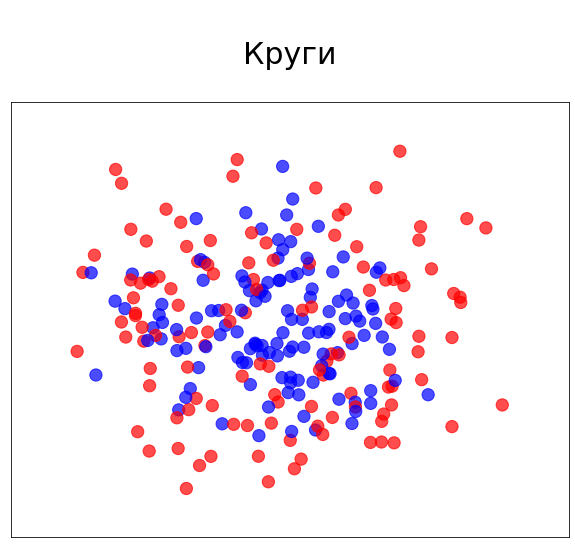

In [40]:
X,y = make_binary_clf(N,method = 'circles')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

fig = plt.figure(figsize= (10,8))
ax = plt.subplot(1, 1, 1)
plot_data(ax,(X,y),
          '\nКруги\n')


In [41]:
def to_polynom(X, order = 2): # функция которая создает подходящее значение полинома
    order_range = range(order, order+1,1)
    out = np.copy(X) 
    for i in order_range:
        out = np.hstack([out, np.power(X,i)])
    return out

In [42]:
X_poly = to_polynom(X, order = 2)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)


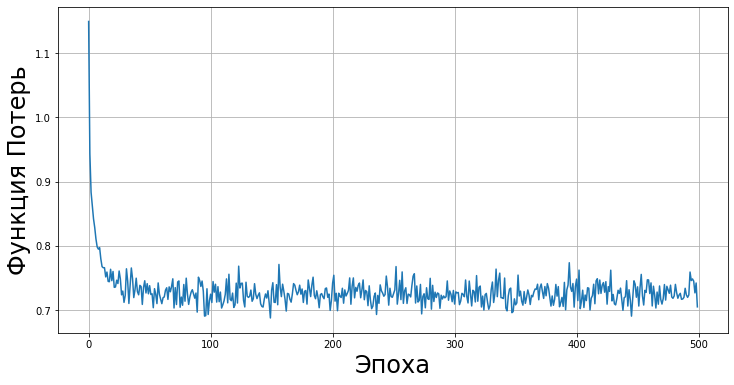

0.5733333333333334 0.5885714285714285
True Positives:0.8182	True Negatives:0.5312
False Positives:0.1818	False Negatives:0.4688
Accuracy:0.5733
Recall:0.2308	Precision:0.8182
f1 measure:0.3600


In [43]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50,
                          )

regr.fit(X_train, y_train)

regr.plot_cost()
print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

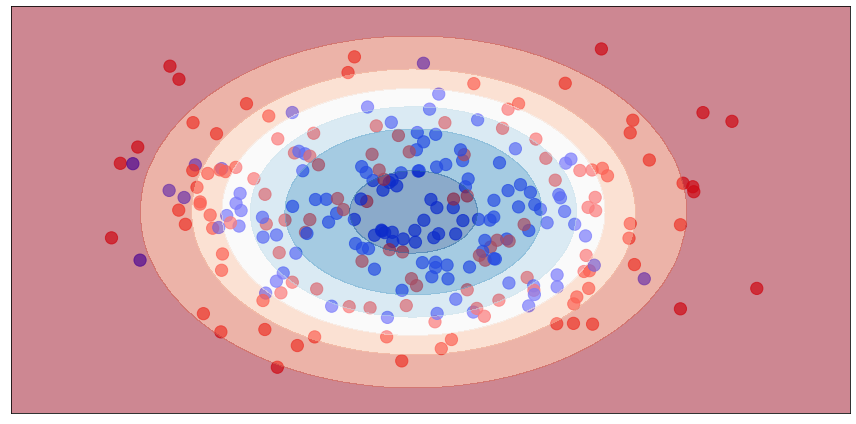

In [44]:
regr.plot_decision_function(X_poly,y,
                            poly = True, order = 2)


### Данные для классификации "Инь-Янь":

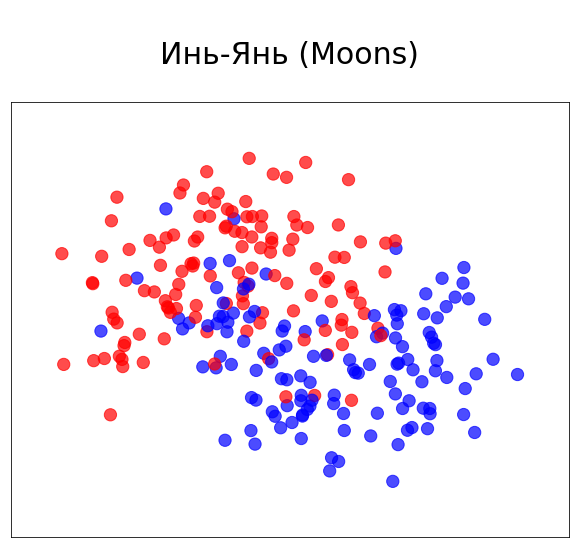

In [45]:
X,y = make_binary_clf(N,method = 'moons')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=89)

fig = plt.figure(figsize= (10,8))
ax = plt.subplot(1, 1, 1)
plot_data(ax,(X,y),
          '\nИнь-Янь (Moons)\n')

In [46]:
X_poly = to_polynom(X, order = 2)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.25, random_state=42)


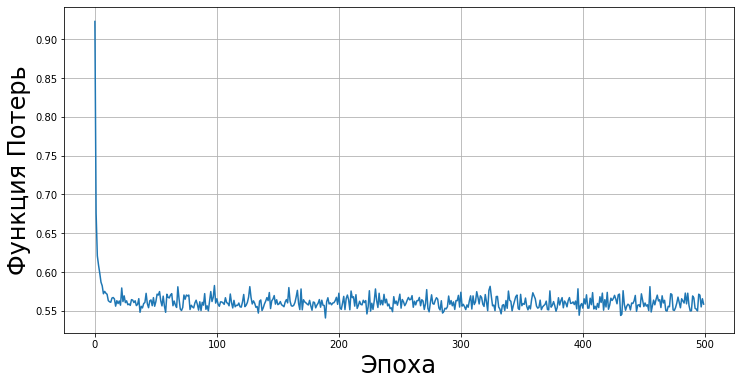

0.7301587301587301 0.7807486631016043
True Positives:0.8636	True Negatives:0.6585
False Positives:0.1364	False Negatives:0.3415
Accuracy:0.7302
Recall:0.5758	Precision:0.8636
f1 measure:0.6909


In [47]:
regr = LogisticRegression(learning_rate=0.4,
                          epochs=500,batch_size=50,
                          )

regr.fit(X_train, y_train)

regr.plot_cost()
print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

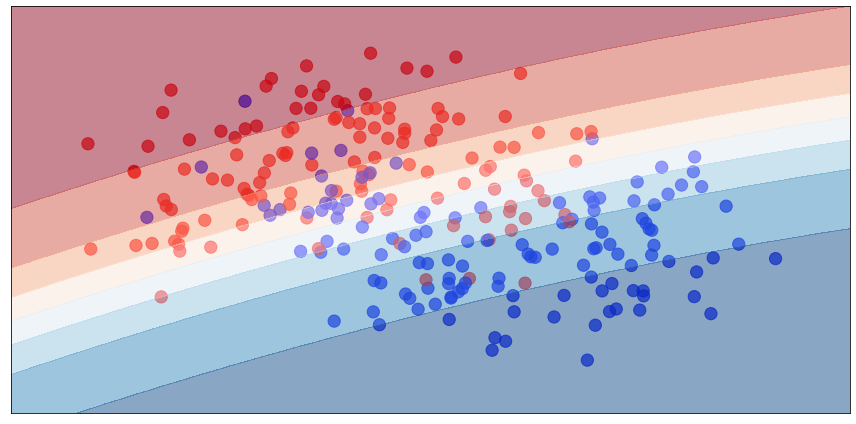

In [48]:
regr.plot_decision_function(X_poly,y,
                            poly = True, order = 2)


## Задание с синтетическими данными. Выводы

Изменение Learning rate на более низкий снижает диапазон скачкой функции потерь, но существенно не влияет на график с собственно классификацией. Также не влияет на метрики

Изменение тестовой выборки почти не повлияло на конечный результат классификации

Увеличение batch_size почему то ухудшило работу модели(с 50 до 100)

Увеличение количество эпох только сделало количество "зубцов" в графике функции потерь больше, но на метрики не повлияло

Увеличение threshold'a(с 0.5 до 0.8) ухудшило работу модели, увеличив ложно-положительные и ложно-отрицательные, что впоследствие уменьшило accuracy и recall

**В итоге, для этой модели наиболее подходящими были метрики
threshold = 0.5
batch_size = 50
остальные метрики оказались не так важны**

# Логистическая регрессия. Работа с датасетом

## Загрузка датасета CarsMoldova
очищенный от дубликатов и выбросов, категориальные данные с помощью One-Hot Encoding превращены в числовые

In [49]:
uploaded = files.upload()

Saving cars_moldova_cat_num.csv to cars_moldova_cat_num (1).csv


In [50]:
df = pd.read_csv('/content/cars_moldova_cat_num.csv', delimiter = ',')
df

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),km_year
0,40,92,2011,4,195000.0,1800.0,2,1,7750.0,17727.272727
1,32,62,2014,11,135000.0,1500.0,0,0,8550.0,16875.000000
2,32,71,2012,11,110000.0,1500.0,0,0,6550.0,11000.000000
3,28,23,2006,11,200000.0,1600.0,3,0,4100.0,12500.000000
4,23,124,2000,5,300000.0,2200.0,0,0,3490.0,13636.363636
...,...,...,...,...,...,...,...,...,...,...
32069,42,88,2016,10,88000.0,1800.0,4,1,11500.0,14666.666667
32070,19,53,2002,3,225000.0,1800.0,3,0,4400.0,11250.000000
32071,6,77,2015,11,89000.0,1500.0,0,0,7000.0,12714.285714
32072,22,10,2006,1,370000.0,2000.0,0,0,4000.0,23125.000000


# Считываем файл в DataFrame

In [51]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission'] 
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year']

# Классификация автомобилей на вторичном рынке Молдавии в зависимости от типа трансмиссии

In [52]:
X = df[num_columns].values  # целевой переменной будет тип трансмиссии
y = df["Transmission"].values 
features_names = df[num_columns].columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # отложенная выборка

scaler  = MinMaxScaler() # нормализация данных
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test) 
pd.DataFrame(X_train).tail()


,0,1,2,3,4
22446,0.64,0.479896,0.353333,0.046092,0.251134
22447,0.74,0.465893,0.479167,0.077144,0.331520
22448,0.70,0.572360,0.333333,0.058106,0.356492
22449,0.70,0.581916,0.375000,0.046593,0.362475
22450,0.24,0.579916,0.000000,0.008016,0.147012


## Tестируем модель без регуляции

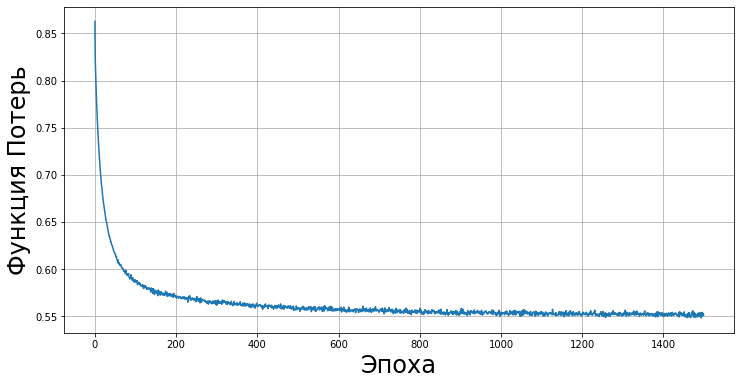

train Accuracy: 0.7375; test Accuracy: 0.7517
True Positives:0.9517	True Negatives:0.6927
False Positives:0.0483	False Negatives:0.3073
Accuracy:0.7517
Recall:0.4776	Precision:0.9517
f1 measure:0.6360


In [53]:
regr = LogisticRegression(learning_rate=0.9,epochs=1500,batch_size=5000) 

regr.fit(X_train, y_train)  # обучение

regr.plot_cost()  # строим график

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))  # доля правильных ответов

regr.classification_report(X_test, y_test)

Оцениваем веса и выявляем большую корреляцию признаков с целевым значением

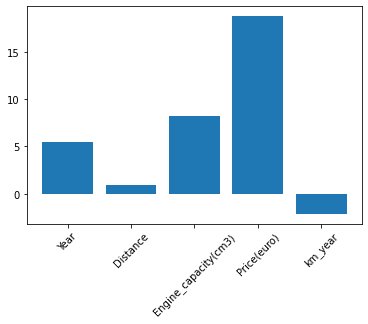

In [54]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

## Проведем тест с L1 регуляризацией

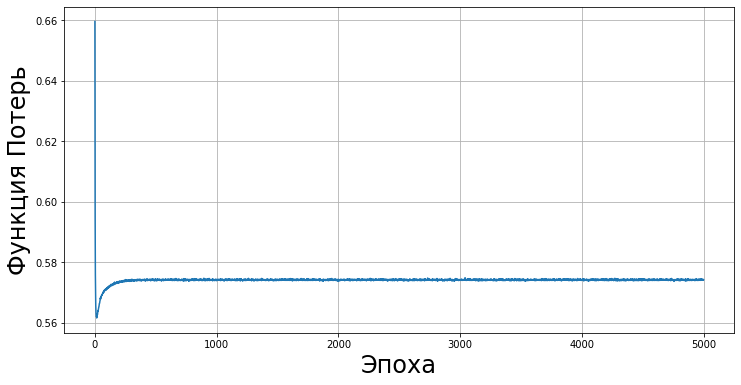

train Accuracy: 0.8065; test Accuracy: 0.8134
True Positives:0.8271	True Negatives:0.8038
False Positives:0.1729	False Negatives:0.1962
Accuracy:0.8134
Recall:0.7446	Precision:0.8271
f1 measure:0.7837


In [74]:
regr = LogisticRegression(learning_rate=0.8,epochs=5000,batch_size=500, l1_penalty = 0.005)
# не понимаю почему так странно график ведет себя, но ф1 метрика нормальная  

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

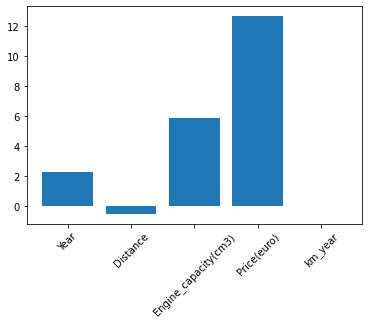

In [56]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

## Эластичная регрессия(комбинация L1 и L2 регуляризаций)

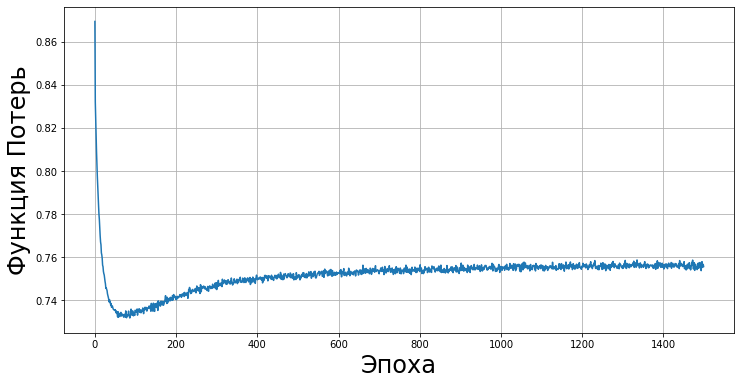

train Accuracy: 0.6553; test Accuracy: 0.6646
True Positives:0.9831	True Negatives:0.6200
False Positives:0.0169	False Negatives:0.3800
Accuracy:0.6646
Recall:0.2659	Precision:0.9831
f1 measure:0.4186


In [68]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000, l1_penalty =  0.008, l2_penalty = 0.00005)
# немного подрегулировала метрики штрафа в регуляризации для уменьшения функции потерь

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

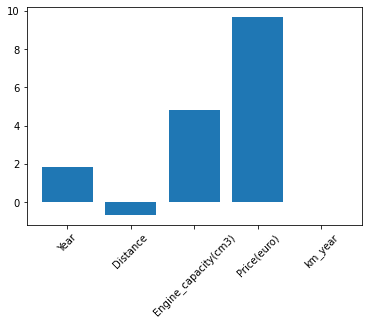

In [58]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

In [75]:
w, b = regr.get_w_and_b() # проверяем можно ли убрать признаки связанные с расстоянием

w[1] = 0
w[-1] = 0

regr = LogisticRegression(learning_rate=0.8,
                          epochs=1500,
                          batch_size=500, 
                          l1_penalty = 0.005,
                          weights = w,
                          bias = b)


print( 'train ACC: %.4f; test ACC: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test) # оказывается можно(это немного улучшает метрики)

train ACC: 0.8051; test ACC: 0.8121
True Positives:0.7964	True Negatives:0.8249
False Positives:0.2036	False Negatives:0.1751
Accuracy:0.8121
Recall:0.7876	Precision:0.7964
f1 measure:0.7920


## Выводы
При анализе числовых признаков "лишними" оказались метрики, связанные с расстоянием(Distance и km_year), поэтому мы уменьшили их веса.
Наиболее значимыми оказалась метрика Цены, пожтому я увеличила веса